# IMOS - AusTemp - Degree Heating Days

|  |  |
| ----------- | ----------- |
| Author:| Leo Li |
| Edited:| Benjamin Stepin |
| Affiliation:| IMOS |
| e-mail:| info@aodn.org.au |
| Date of creation:| 2nd Apr., 2025 |
| Date of last update:| 7nd May., 2025 |

## Table of Contents
#### [Background](#background-what)
#### [Required Packages](#required)

### [Visualisation of AusTemp - Degree Heating Days ](#vis)


<a name="background-what"></a>
## Background

This dataset contains the summer Degree Heating Days (DHD) from the 1st of December to the 30th of April since 2024, which is calculated by accumulating the daily positive Sea Surface Temperature anomalies (SSTa). The SSTa is calculated by comparing the current SST to long-term averages (1993-2003, the “CSIRO Legacy climatology” or 2002-2011, the “IMOS climatology”). The magnitude of the DHD correlates well with past coral bleaching events. In cases where SST cannot be calculated due to cloud cover, the grid cell is left blank (white in web plots, transparent in Google Earth) to indicate missing data.

The ReefTemp Next Generation (RTNG) system was implemented and declared operational in the Bureau National Operations Centre (BNOC, formerly National Meteorological and Oceanographic Centre) on 22 October 2013. The system is based on a new state-of-the-art Integrated Marine Observing System (IMOS) 1-day L3S night-only Sea Surface Temperature (SST) product, which produces high-resolution satellite-based nowcasts of SST, thermal stress and associated coral bleaching risk over the Great Barrier Reef.

This product follows on from the decommissioned ReefTemp Next Generation a high resolution mapping product that provided information on coral bleaching risk for the Great Barrier Reef region. The ReefTemp Next Generation system was developed by the Bureau of Meteorology for eReefs, under the National Plan for Environmental Information (NPEI) initiative. A research Version 1 (V1) system, available from 2007, was the result of a collaborative project between the Bureau of Meteorology, CSIRO Marine and Atmospheric Research and the Great Barrier Reef Marine Park Authority.

### Required Packages <a name="required"></a>

xarray==2024.7.0 \
pandas==2.2.2 \
numpy==2.1.1 \
matplotlib==3.9.2 \
scipy==1.14.1 \
cartopy==0.23.0 \
geopandas==1.0.1 \
zarr==2.18.1 \
cmocean==4.0.3 \
s3fs==2024.10.0 

In [2]:
# Environment setting for the notebook
# %pip install \
# xarray==2024.7.0 \
# pandas==2.2.2 \
# numpy==2.1.1 \
# matplotlib==3.9.2 \
# scipy==1.14.1 \
# cartopy==0.23.0 \
# geopandas==1.0.1 \
# zarr==2.18.1 \
# cmocean==4.0.3 \
# s3fs==2024.10.0 

# Visualization for the dataset of `satellite_austemp_degree-heating-day_australia.zarr` <a name="vis"></a>
#### This notebook demos how to use the Cloud Optimised Data (ZARR) of satellite_austemp_degree-heating-day_australia.zarr to extract and plot variables.

In [1]:
import xarray as xr
import s3fs 
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import geopandas as gpd
from matplotlib.colors import ListedColormap
import pandas as pd
from shapely.geometry import box

### Functions to plot variables

In [2]:

# The function refers the BOM austemp repo and modified for DHD plot by using zarr
# https://github.com/bomRob/austemp/blob/dev/src/plot_dhd.py
def plot_dhd_by_date(
    zarr, 
    variable,
    date, 
    lat_min, 
    lat_max, 
    lon_min, 
    lon_max, 
    title,
    output_file=None, 
    marine_parks_file=None,
    major_cities = [
        {"name": "Sydney", "lat": -33.8688, "lon": 151.2093},
        {"name": "Brisbane", "lat": -27.4698, "lon": 153.0251},
        {"name": "Perth", "lat": -31.9505, "lon": 115.8605},
        {"name": "Adelaide", "lat": -34.9285, "lon": 138.6007},
        {"name": "Darwin", "lat": -12.46113, "lon": 130.84185},
        {"name": "Townsville", "lat": -19.26639, "lon": 146.80569},
        {"name": "Cairns", "lat": -16.92366, "lon": 145.76613},
        {"name": "Rockhampton", "lat": -23.38032, "lon": 150.50595}
    ] 
):
    """
    Plot the Degree Heating Days (DHD) data for a specific date by using zarr.
    
    Parameters:
        zarr (xr.Dataset): The xarray dataset containing the DHD data.
        variable (str): The variable name chose from zarr variables.
        date (str): The date in the format 'YYYY-MM-DD' to plot.
        lat_min (float): The minimum latitude for the plot domain.
        lat_max (float): The maximum latitude for the plot domain.
        lon_min (float): The minimum longitude for the plot domain.
        lon_max (float): The maximum longitude for the plot domain.
        output_file (str): The file path to save the plot as an image (e.g., 'dhd_plot.png').
        marine_parks_file (str): The file path to the marine parks shapefile for plotting.
    """

    # Define custom color palette for DHD plot
    ReeftempNG_DHD = [
        '#6B9E56', '#9EC08A', '#D1E2BE', '#FFFFCC', '#FFFF00', '#FFE900', 
        '#FFBF00', '#FF8A00', '#FF5F00', '#FF0900', '#EB0000', '#B30000', 
        '#890000', '#4C0000', '#390000', '#130000'
    ]

    # Define colorbar ticks for DHD plot
    colbar_ticks = np.arange(0, 170, 10)  # 0 to 160 in increments of 10


    plt.figure(figsize=(10, 8), dpi=120)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Select the DHD data for the given date and variable
    data = zarr.sel(time=date)[variable]

    # Set plot extent based on domain
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Squeeze to remove singleton dimensions
    data = data.squeeze()

    # Set DHD values of 0 to NaN, so they will be plotted as white
    data = data.where(data != 0, np.nan)

    # Set vmin and vmax for colorbar alignment
    vmin = 0
    vmax = 160

    # Plot the data with a custom colormap and custom colorbar ticks
    data.plot(ax=ax, cmap=ListedColormap(ReeftempNG_DHD), transform=ccrs.PlateCarree(), 
              vmin=vmin, vmax=vmax,  # Set the colorbar range
              cbar_kwargs={
                  'label': '(\u00b0C Days)',
                  'ticks': colbar_ticks  # Apply the custom ticks
              })
    
    # Add land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor='k', facecolor='#D3D3D3', zorder=100)
    ax.add_feature(cfeature.COASTLINE, zorder=101)

    # Add major cities to the plot if they are within the domain
    for city in major_cities:
        if lat_min <= city["lat"] <= lat_max and lon_min <= city["lon"] <= lon_max:
            # Plot black point for the city
            ax.plot(city["lon"], city["lat"], marker='o', color='black', markersize=5, 
                    transform=ccrs.PlateCarree(), zorder=110)
            
            # Add label to the left of the city point
            ax.text(city["lon"] - 0.2, city["lat"], city["name"], transform=ccrs.PlateCarree(), 
                    fontsize=10, verticalalignment='center', horizontalalignment='right', 
                    zorder=111, color='black')
    
    # Add marine park boundaries if provided
    if marine_parks_file is not None:
        marine_parks = gpd.read_file(marine_parks_file)

        # Filter for GBR and Australian EEZ parks
        marine_parks_gbr = marine_parks[marine_parks['NAME'].str.contains("Great Barrier Reef", case=False)]

        # Define bounding box for the lat/lon bounds
        bounding_box = box(lon_min, lat_min, lon_max, lat_max)
        
        # Clip the parks to the bounding box
        marine_parks_gbr_clipped = gpd.clip(marine_parks_gbr, bounding_box)

        # Plot the clipped marine parks
        ax.add_geometries(marine_parks_gbr_clipped.geometry, crs=ccrs.PlateCarree(), facecolor='none', 
                          edgecolor='black', linewidth=1, zorder=105, label='GBR Area')

    # Add grid labels
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=111)
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.left_labels = True   # Enable left labels (latitude)
    gl.bottom_labels = True  # Enable bottom labels (longitude)

    # Manually add a small legend in the bottom-left corner
    legend_x = 0.02  # x position of the legend box
    legend_y = 0.05  # y position of the legend box

    # Add a white box for "No Data"
    ax.add_patch(mpatches.Rectangle((legend_x, legend_y), 0.02, 0.02, transform=ax.transAxes, 
                                    color='white', ec='black', lw=1, zorder=112))
    ax.text(legend_x + 0.03, legend_y + 0.01, "No Data", transform=ax.transAxes, 
            fontsize=10, verticalalignment='center', zorder=113)

    # Add a light grey box for "Land"
    ax.add_patch(mpatches.Rectangle((legend_x, legend_y - 0.03), 0.02, 0.02, transform=ax.transAxes, 
                                    color='#D3D3D3', ec='black', lw=1, zorder=112))
    ax.text(legend_x + 0.03, legend_y - 0.02, "Land", transform=ax.transAxes, 
            fontsize=10, verticalalignment='center', zorder=113)

    # Add thick black border using plt.Rectangle
    rect = plt.Rectangle((0, 0), 1, 1, transform=ax.transAxes, 
                         linewidth=3, edgecolor='black', facecolor='none', zorder=120)
    ax.add_patch(rect)

    # Save the plot
    plt.title(title)
    
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Plot saved to {output_file}")


### Connect to the data of `austemp_degree-heating-day_australia` from s3

In [3]:

dhd_zarr_path = "s3://aodn-cloud-optimised/satellite_austemp_degree-heating-day_australia.zarr/"
fs = s3fs.S3FileSystem(anon=True)
dhd_zarr_store = s3fs.S3Map(root=dhd_zarr_path, s3=fs)

data = xr.open_zarr(dhd_zarr_store)
data

<xarray.Dataset> Size: 76GB
Dimensions:           (time: 289, lat: 1890, lon: 2685)
Coordinates:
  * lat               (lat) float32 8kB -8.21 -8.23 -8.25 ... -45.97 -45.99
  * lon               (lon) float32 11kB 110.0 110.0 110.1 ... 163.6 163.7 163.7
  * time              (time) datetime64[ns] 2kB 2023-12-01T15:20:00 ... 2025-...
Data variables:
    dhd               (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    dhd_count         (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    dhd_count_mosaic  (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    dhd_mosaic        (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    dhd_mosaic_age    (time, lat, lon) float32 6GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    mpsa              (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    mpsa_mosaic       (time, lat, lon) float64 12GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.6,IMOS-1.4
    abstract:                   This dataset contains the summer Degree Heati...
    acknowledgement:            Any users of IMOS data are required to clearl...
    author:                     Australian Ocean Data Network (AODN)
    author_email:               info@aodn.org.au
    cdm_data_type:              grid
    ...                         ...
    spatial_resolution:         0.02
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    start_time:                 20120101T122957Z
    stop_time:                  99991231T214701Z
    summary:                    AusTemp is a specialised remote sensing appli...
    title:                      Nighttime AusTemp: Degree Heating Days DHD gr...

#### Quick plot numerical variable of the latest datetime

dhd


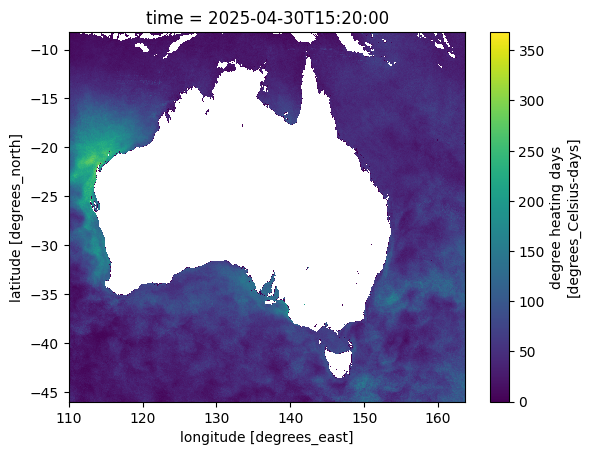

dhd_count


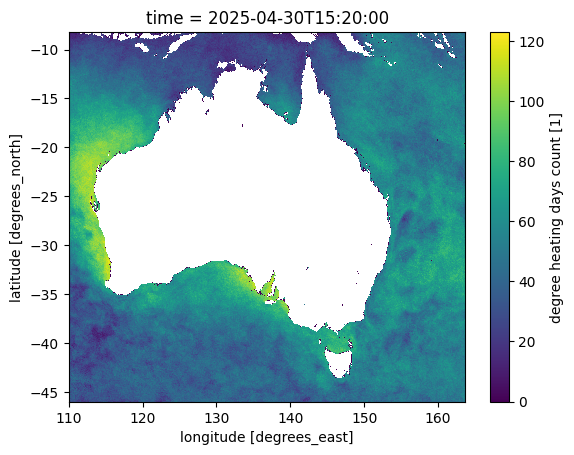

dhd_count_mosaic


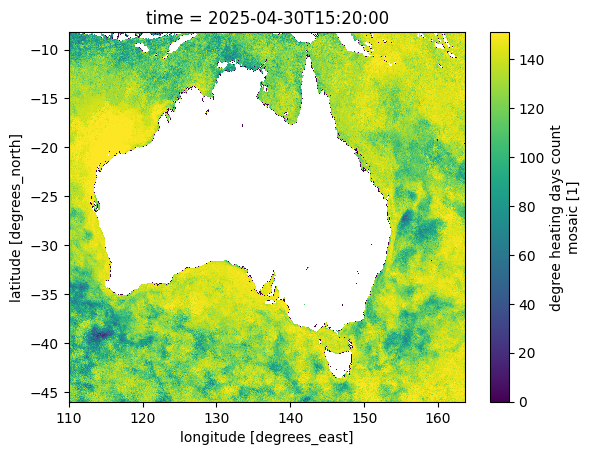

dhd_mosaic


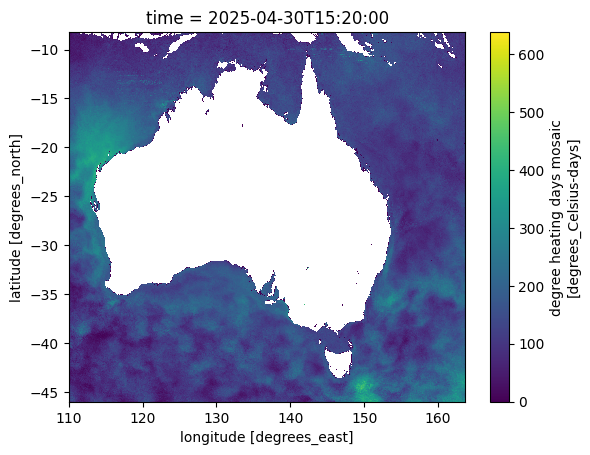

dhd_mosaic_age


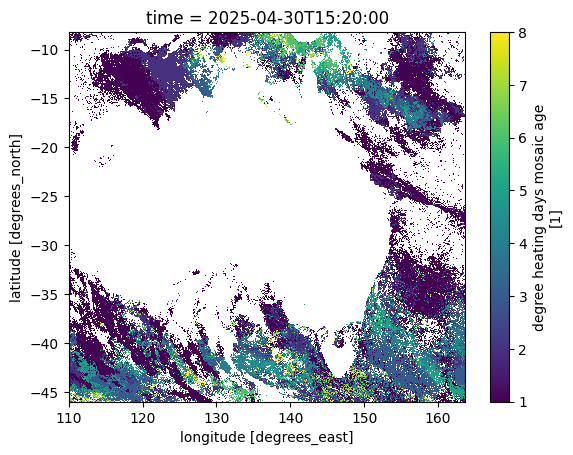

mpsa


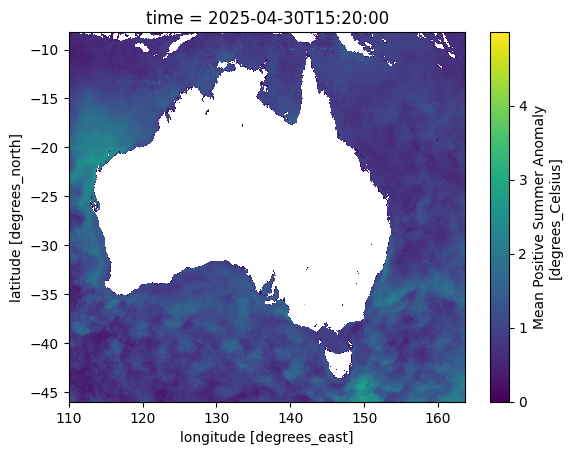

mpsa_mosaic


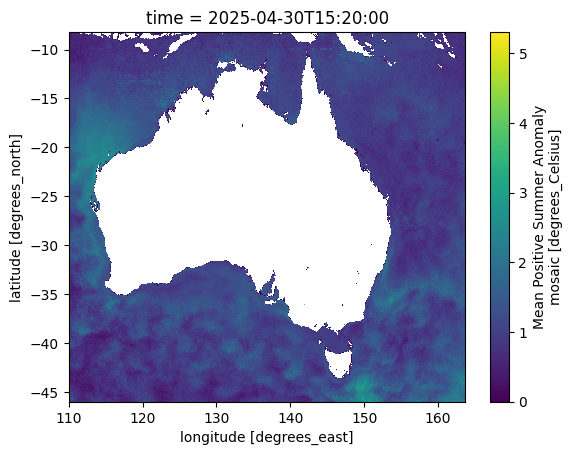

In [4]:
for var in data.data_vars:
    print(var)
    try:
        data[var].isel(time=-1).plot()
        plt.show()
    except:
        # "Variable {var} is not numerical datatype. Skipping plot."
        continue

#### Analyst a week temperature changes for the variable `dhd` 

In [5]:

dhd1_202403 = data.sel(time=slice('2024-03-01', '2024-03-07')).dhd
dhd1_202403

<xarray.DataArray 'dhd' (time: 7, lat: 1890, lon: 2685)> Size: 284MB
dask.array<getitem, shape=(7, 1890, 2685), dtype=float64, chunksize=(1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 8kB -8.21 -8.23 -8.25 -8.27 ... -45.95 -45.97 -45.99
  * lon      (lon) float32 11kB 110.0 110.0 110.1 110.1 ... 163.6 163.7 163.7
  * time     (time) datetime64[ns] 56B 2024-03-01T15:20:00 ... 2024-03-07T15:...
Attributes:
    _ChunkSizes:  [1, 500, 500]
    comment:      Cumulative measure of heat stress above a defined temperatu...
    long_name:    degree heating days
    units:        degrees_Celsius-days
    valid_max:    500.0
    valid_min:    0.0

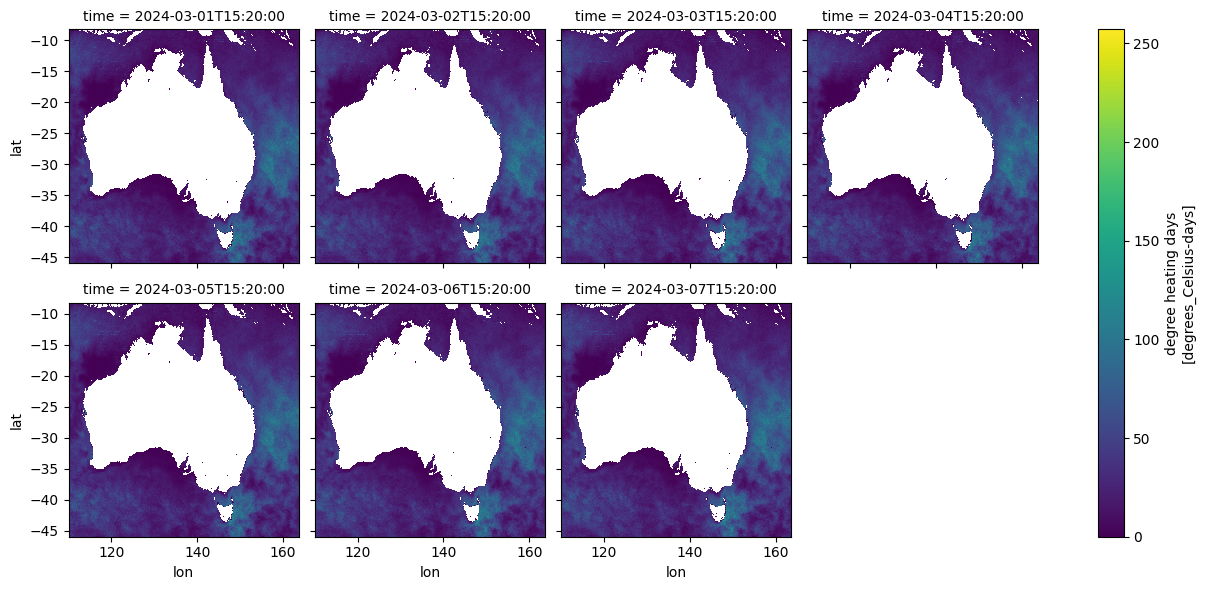

In [6]:
dhd1_202403.plot(col='time', col_wrap=4)

#### Quick plot of the `dhd` located at `Square Reef`
Google Map of `Square Reef` : https://www.google.com/maps/place/20%C2%B000'00.0%22S+150%C2%B000'00.0%22E/@-20.0534848,149.7645284,13.07z/data=!4m4!3m3!8m2!3d-20!4d150?authuser=0&entry=ttu&g_ep=EgoyMDI0MTIwMy4wIKXMDSoASAFQAw%3D%3D

In [7]:
Square_Reef_dhd1_2024 = data.sel(lat=-20.067047, lon=149.812109, method="nearest")\
    .sel(time=slice('2023-12-01', '2024-3-31'))\
    .dhd
Square_Reef_dhd1_2024

<xarray.DataArray 'dhd' (time: 122)> Size: 976B
dask.array<getitem, shape=(122,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 4B -20.07
    lon      float32 4B 149.8
  * time     (time) datetime64[ns] 976B 2023-12-01T15:20:00 ... 2024-03-31T15...
Attributes:
    _ChunkSizes:  [1, 500, 500]
    comment:      Cumulative measure of heat stress above a defined temperatu...
    long_name:    degree heating days
    units:        degrees_Celsius-days
    valid_max:    500.0
    valid_min:    0.0

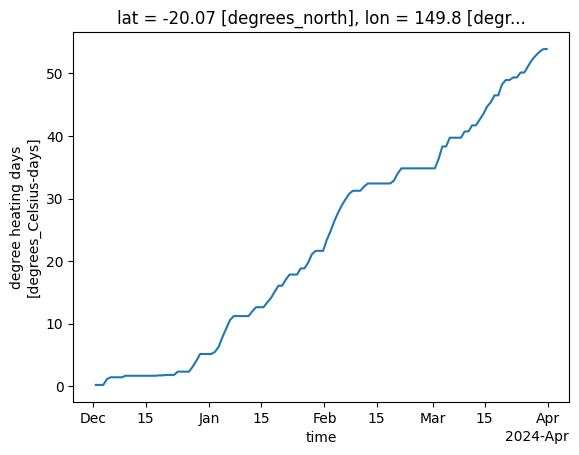

In [8]:
Square_Reef_dhd1_2024.plot()

#### Quick plot every variable of the whole year of 2024 located at `Square Reef`

dhd


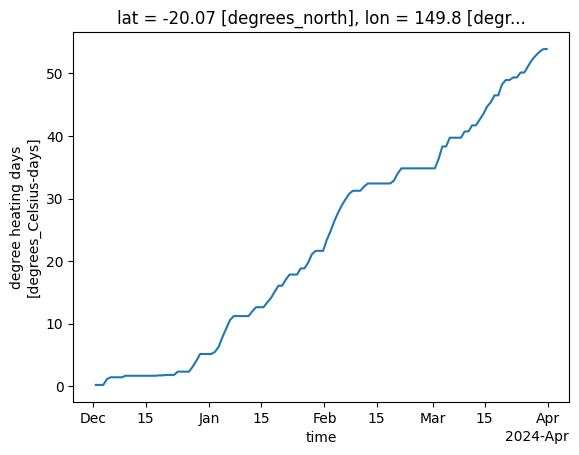

dhd_count


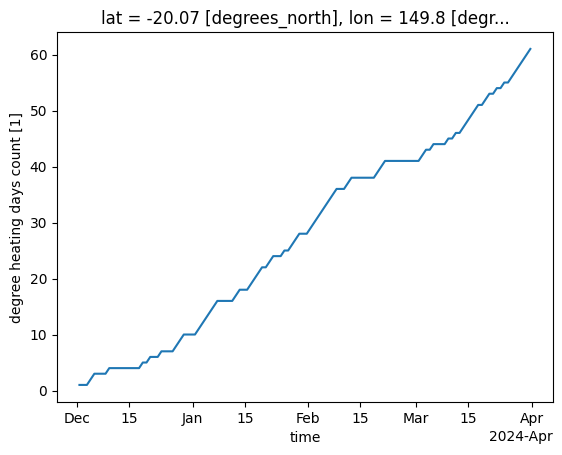

dhd_count_mosaic


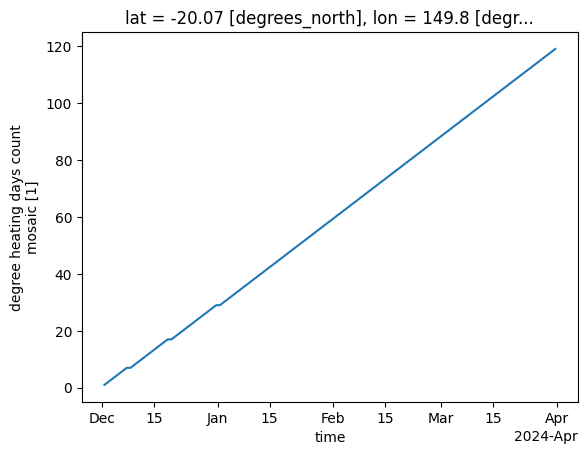

dhd_mosaic


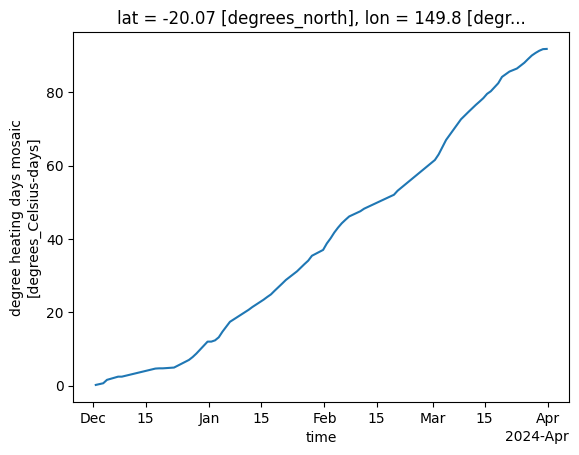

dhd_mosaic_age


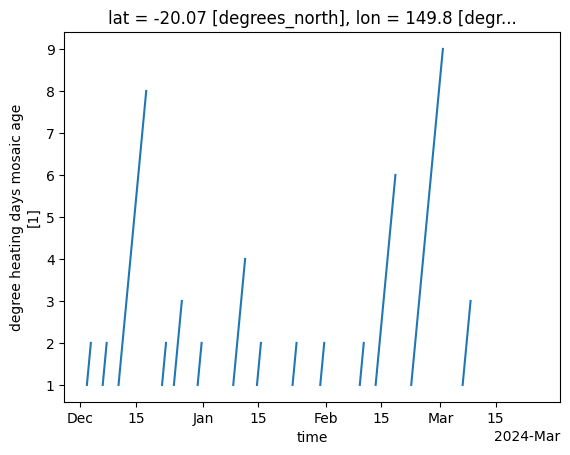

mpsa


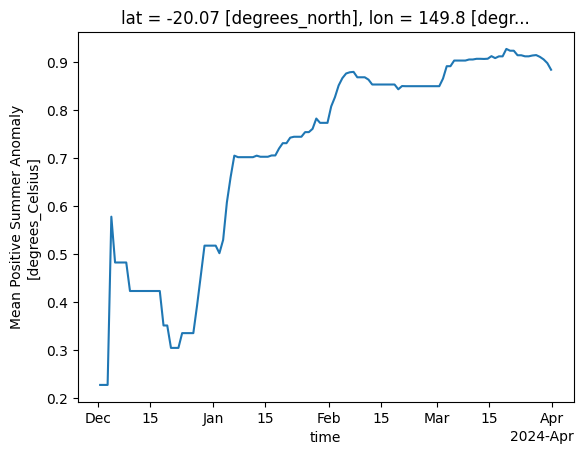

mpsa_mosaic


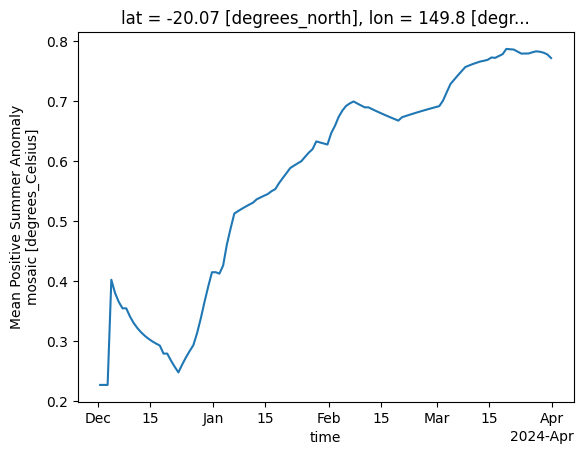

In [9]:
for var in data.data_vars:
    print(var)
    try:
        data[var].sel(lat=-20.067047, lon=149.812109, method="nearest")\
        .sel(time=slice('2023-12-01', '2024-3-31'))\
        .plot()
        plt.show()
    except:
        print(f"Could not plot {var}")
        continue

### Check the calculations using the entire grid
Below, we will create a new variable that will contain the `dhd1` (dhd-1day) data for 2024. 

We will then calculate a monthly mean and finally we plot the results to see the monthly mean temperature.

In [10]:
# Check the grouping and caculate speed with a whole year
dhd1_2024 = data.dhd.sel(time=slice('2023-12-01', '2024-03-31'))
dhd1_2024

<xarray.DataArray 'dhd' (time: 122, lat: 1890, lon: 2685)> Size: 5GB
dask.array<getitem, shape=(122, 1890, 2685), dtype=float64, chunksize=(1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 8kB -8.21 -8.23 -8.25 -8.27 ... -45.95 -45.97 -45.99
  * lon      (lon) float32 11kB 110.0 110.0 110.1 110.1 ... 163.6 163.7 163.7
  * time     (time) datetime64[ns] 976B 2023-12-01T15:20:00 ... 2024-03-31T15...
Attributes:
    _ChunkSizes:  [1, 500, 500]
    comment:      Cumulative measure of heat stress above a defined temperatu...
    long_name:    degree heating days
    units:        degrees_Celsius-days
    valid_max:    500.0
    valid_min:    0.0

In [11]:
dhd1_2024_monthly = dhd1_2024.groupby("time.month").mean()
dhd1_2024_monthly

<xarray.DataArray 'dhd' (month: 4, lat: 1890, lon: 2685)> Size: 162MB
dask.array<transpose, shape=(4, 1890, 2685), dtype=float64, chunksize=(1, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 8kB -8.21 -8.23 -8.25 -8.27 ... -45.95 -45.97 -45.99
  * lon      (lon) float32 11kB 110.0 110.0 110.1 110.1 ... 163.6 163.7 163.7
  * month    (month) int64 32B 1 2 3 12
Attributes:
    _ChunkSizes:  [1, 500, 500]
    comment:      Cumulative measure of heat stress above a defined temperatu...
    long_name:    degree heating days
    units:        degrees_Celsius-days
    valid_max:    500.0
    valid_min:    0.0

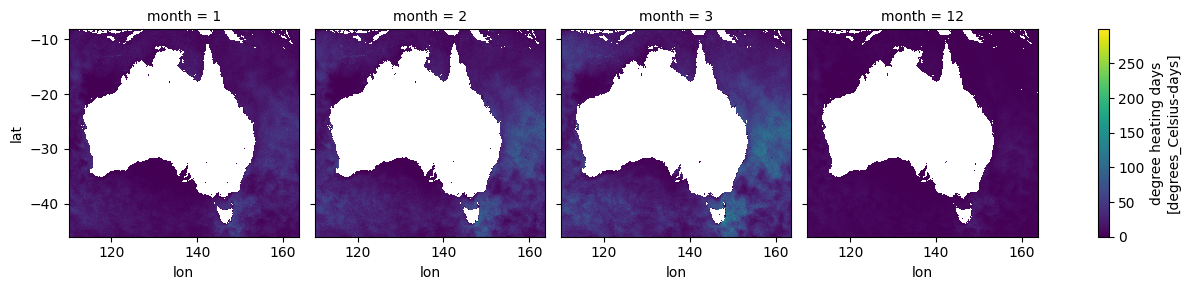

In [12]:
dhd1_2024_monthly.plot(col='month', col_wrap=4)

## The demo for BOM to plot DHD by using zarr

Plot saved to dhd_plot_2024-01-30.png


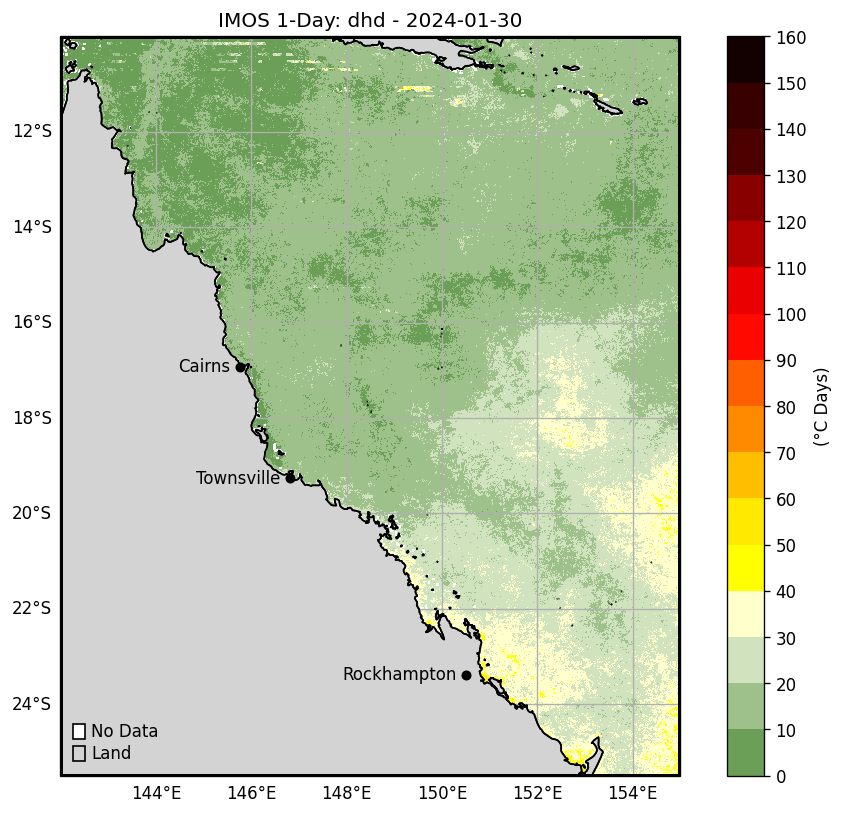

In [13]:
# Plot the variable "DHD" for a specific date from zarr

selected_date = "2024-01-30"
variable = "dhd"
output_file = f"dhd_plot_{selected_date}.png"
title = f"IMOS 1-Day: { variable} - {selected_date}"


# Define the domain (GBR REGION) for the plot
lat_min = -25.5
lat_max = -10.0
lon_min = 142.0
lon_max = 155.0

plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

Plot saved to dhd_plot_2024-03-30.png


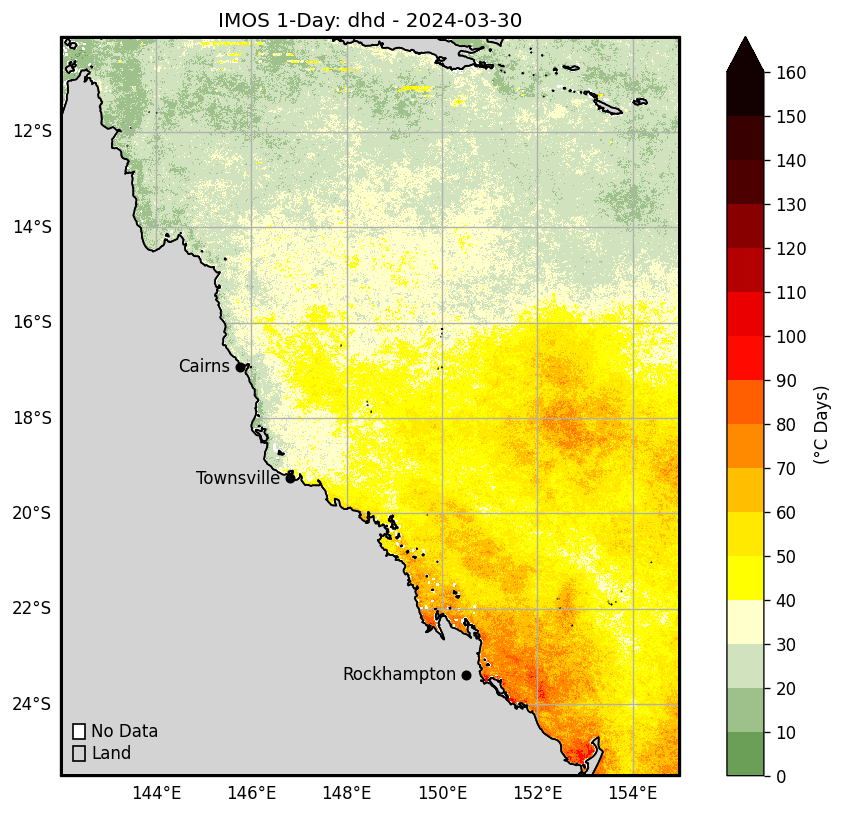

In [14]:
# Plot the variable "DHD" for a specific date from zarr

selected_date = "2024-03-30"
variable = "dhd"
output_file = f"dhd_plot_{selected_date}.png"
title = f"IMOS 1-Day: { variable} - {selected_date}"


# Define the domain (GBR REGION) for the plot
lat_min = -25.5
lat_max = -10.0
lon_min = 142.0
lon_max = 155.0

plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

# Plot the variable "dhd_mosaic" for a specific date from zarr

Plot saved to dhd_mosaic_plot_2024-01-30.png


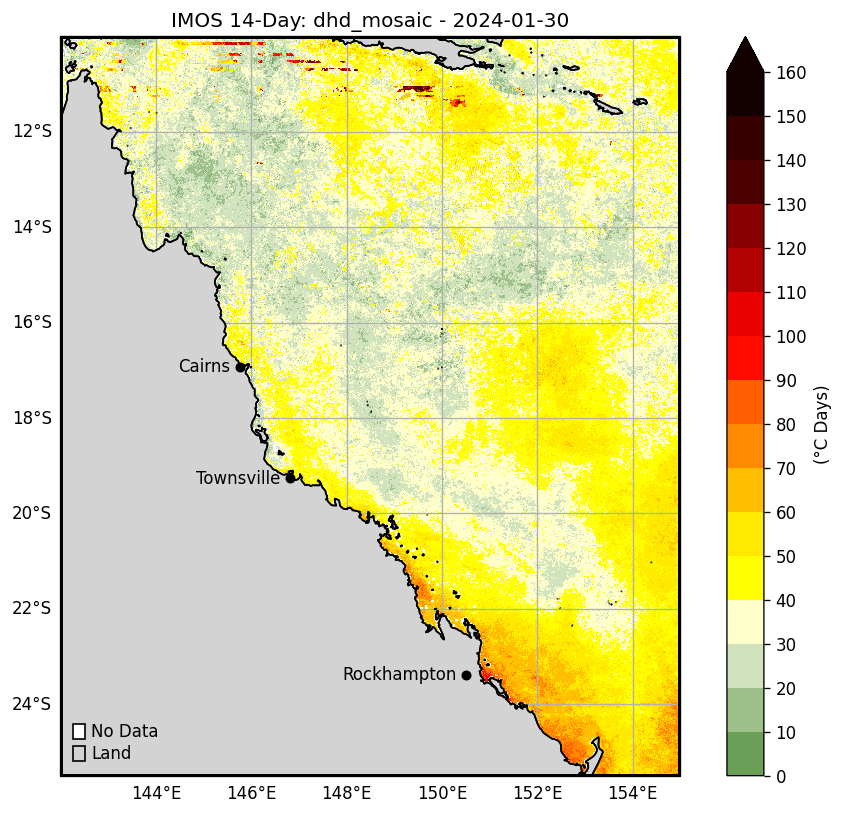

In [15]:

selected_date = "2024-01-30"
variable = "dhd_mosaic"
output_file = f"dhd_mosaic_plot_{selected_date}.png"
title = f"IMOS 14-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

Plot saved to dhd_mosaic_plot_2024-03-30.png


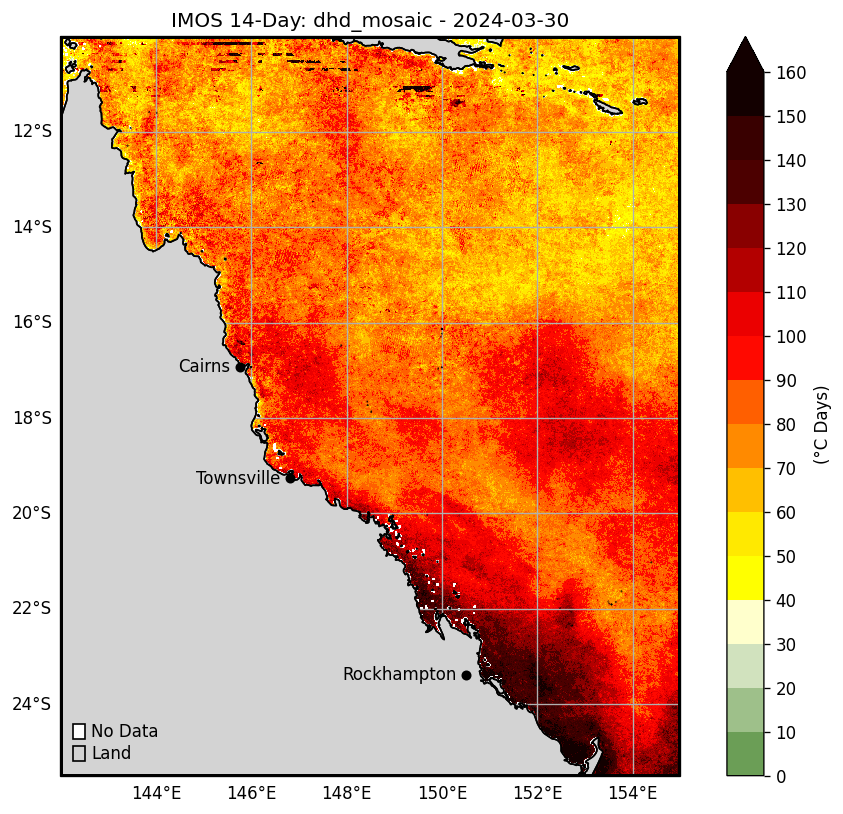

In [16]:

selected_date = "2024-03-30"
variable = "dhd_mosaic"
output_file = f"dhd_mosaic_plot_{selected_date}.png"
title = f"IMOS 14-Day: { variable} - {selected_date}"
plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title,  output_file=output_file)

## Plot TASMANIA region

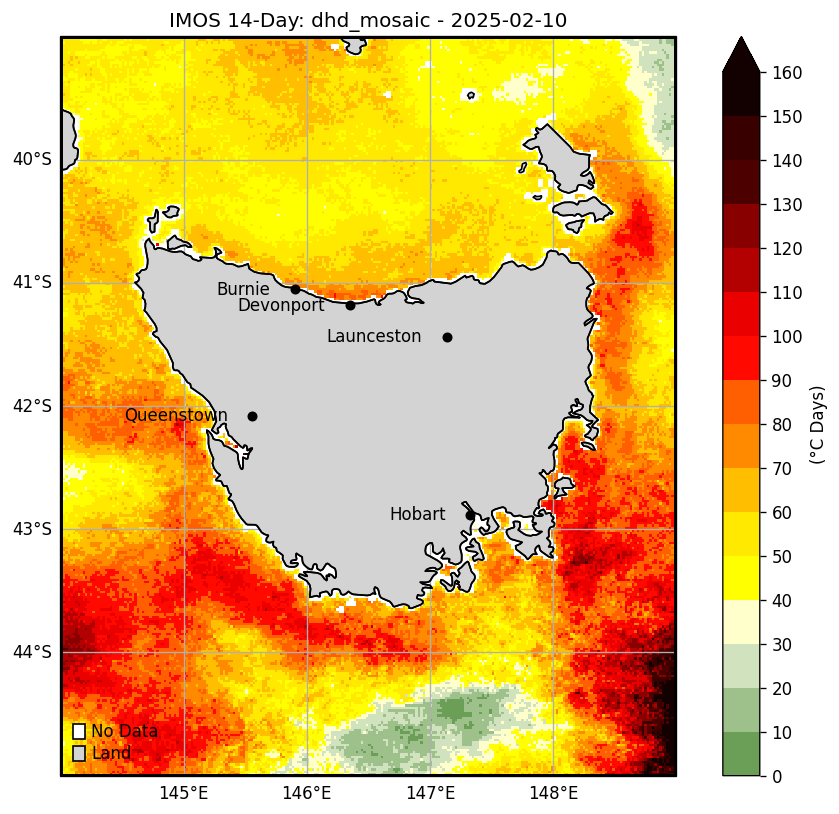

In [17]:
selected_date = "2025-02-10"
variable = "dhd_mosaic"
title = f"IMOS 14-Day: { variable} - {selected_date}"


lat_min = -45
lat_max = -39
lon_min = 144
lon_max = 149

major_cities = [
    {"name": "Hobart", "lat": -42.8821, "lon": 147.3272},
    {"name": "Launceston", "lat": -41.4388, "lon": 147.1349},
    {"name": "Devonport", "lat": -41.1806, "lon": 146.3500},
    {"name": "Burnie", "lat": -41.0524, "lon": 145.9060},
    {"name": "Queenstown", "lat": -42.0801, "lon": 145.5582}
]

plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title, major_cities=major_cities)

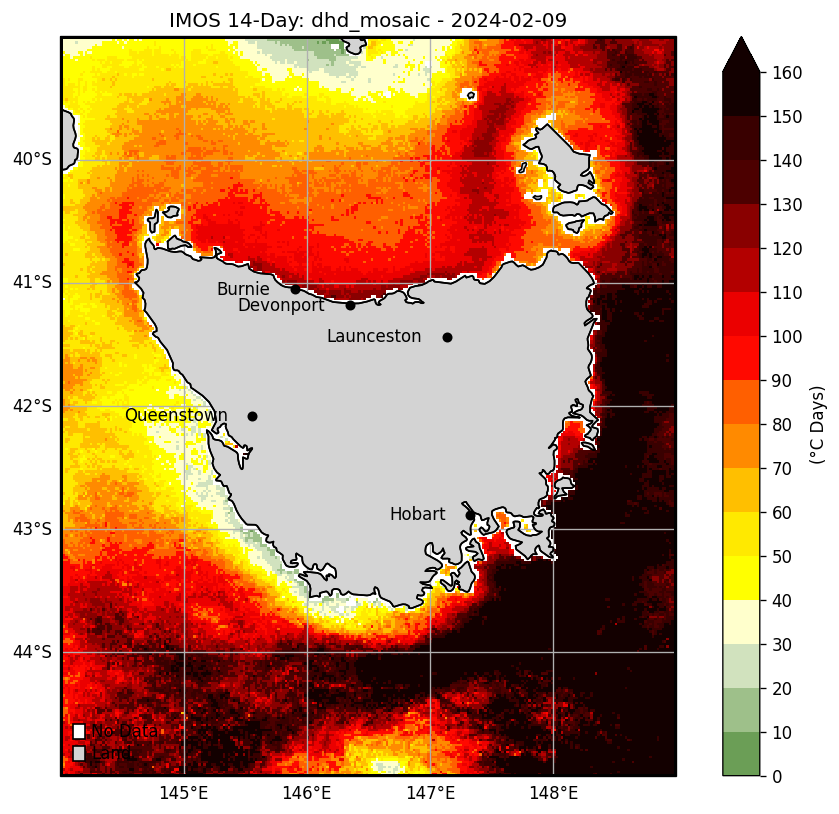

In [18]:
selected_date = "2024-02-09"
variable = "dhd_mosaic"
title = f"IMOS 14-Day: { variable} - {selected_date}"


# Define the domain (Tas REGION) for the plot
lat_min = -45
lat_max = -39
lon_min = 144
lon_max = 149

major_cities = [
    {"name": "Hobart", "lat": -42.8821, "lon": 147.3272},
    {"name": "Launceston", "lat": -41.4388, "lon": 147.1349},
    {"name": "Devonport", "lat": -41.1806, "lon": 146.3500},
    {"name": "Burnie", "lat": -41.0524, "lon": 145.9060},
    {"name": "Queenstown", "lat": -42.0801, "lon": 145.5582}
]

plot_dhd_by_date(data, variable, selected_date, lat_min, lat_max, lon_min, lon_max,title, major_cities=major_cities)